In [ ]:
# import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
use_builtins = True

In [3]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return
  
    if isinstance(names, str):
      names = (names,)
    
    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                      f'  found {rank}: {shape.numpy()}\n'
                      f'  expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                        f"  found: {new_dim}\n"
                        f"  expected: {old_dim}\n")                 

In [4]:
def load_path(path):
  text = path.read_text(encoding='utf-8', errors='replace')

  lines = text.splitlines()
  pairs = [line.split('| $sep$ |') for line in lines]

  comm = [comm for comm, targ in pairs]
  reply = [reply for comm, reply in pairs]

  return comm, reply

In [5]:
import pathlib
comm, reply = load_path(pathlib.Path('final.txt'))

In [6]:
comm1, reply1 = [], []
for (c, r) in zip(comm, reply):
  if len(c)<=240 and len(r)<=240:
    comm1.append(c)
    reply1.append(r)

In [7]:
comm, reply = comm1, reply1

In [8]:
BUFFER_SIZE = len(reply)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((comm, reply)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for ex_c, ex_r in dataset.take(1):
  print(ex_c[:4], end="\n")
  print(ex_r[:4])  

tf.Tensor(
[b"I don't like the way you eat chips."
 b'Everyone else in the meeting:. Fuck, why does this guy from that irrelevant division keep asking questions and dragging out this meeting?'
 b'Dude how did you get a video of my son after I ask him to brush his teeth?'
 b"Had the honor of being a casket bearer at John Lewis' funeral. What a moving experience."], shape=(4,), dtype=string)
tf.Tensor(
[b'You know how people hold up those signs saying "if you\'re looking for a reason not to kill yourself this is it"?This is the opposite'
 b'"Omg THAT guy again?"'
 b'"Can you put that down?"*throws it across the fucking room'
 b'I walked past him at Reagan airport once. Didn\'t realize it was him till I passed. I might have said out load "holy shit that was John Lewis". Or maybe it was just in my head. I wish I went back.'], shape=(4,), dtype=string)


# Text Preprocessing

In [10]:
def tf_lower_and_split_punct(text):
  text = tf.strings.lower(text)
  # Keeping space, a to z, and select punctuation
  text = tf.strings.regex_replace(text, '[^ a-z.?!,\']', '')
  # Add spaces around punctuation
  text = tf.strings.regex_replace(text, '[.?!,\']', r' \0 ')
  # Strip whitespace
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [11]:
print(tf_lower_and_split_punct(tf.constant('Hello world! " How\'s it going?').numpy().decode()))

tf.Tensor(b"[START] hello world !   how ' s it going ? [END]", shape=(), dtype=string)


In [12]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

In [13]:
input_text_processor.adapt(comm+reply)

In [14]:
example_tokens = input_text_processor(ex_c)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   3,    8,   53,    6,   20,   27,    5,  102,   16,  340],
       [   3,  203,  258,   18,    5, 2038,    2,  147,    7,   80],
       [   3,  183,   58,   87,   16,   61,    9,  165,   14,   29]],
      dtype=int64)>

In [15]:
vocab = np.array(input_text_processor.get_vocabulary())
tokens = vocab[example_tokens[0].numpy()]
' '.join(tokens)

"[START] i don ' t like the way you eat chips . [END]                                        "

Text(0.5, 1.0, 'Mask')

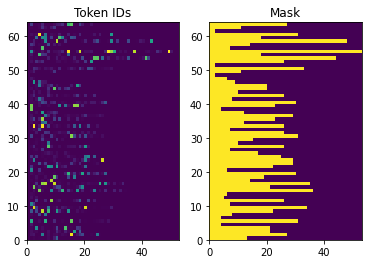

In [16]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [17]:
embedding_dim = 256
units = 1024

In [18]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

    # The GRU RNN layer processes those vectors sequentially
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # The embedding layers looks up the embedding for each token
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # The GRU processes the embedding sequence
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # Returns the new sequence and its state
    return output, state

In [19]:
example_tokens = input_text_processor(ex_c)
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)

example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {ex_c.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 53)
Encoder output, shape (batch, s, units): (64, 53, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()
  
  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # W1@ht
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # W2@hs
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask = [query_mask, value_mask],
        return_attention_scores=True
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(units)
example_tokens.shape

TensorShape([64, 53])

In [22]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units):  {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):  (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 53)


Text(0.5, 1.0, 'Mask')

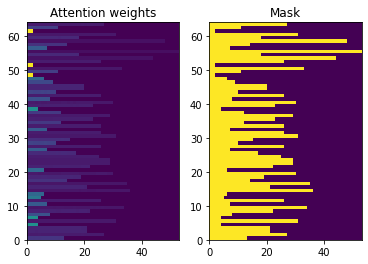

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [24]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

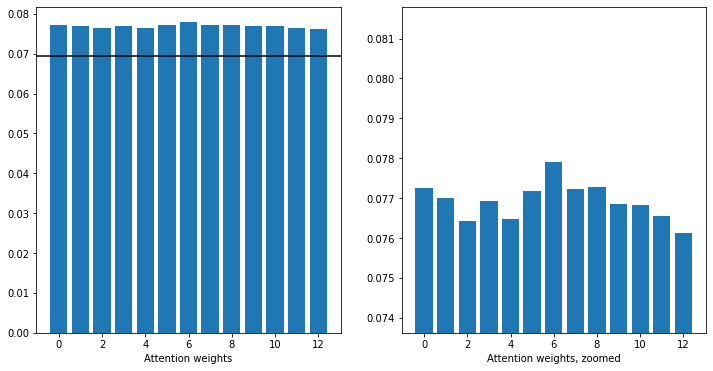

In [25]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [26]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any
  
class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim


    # Convert token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, 
                                               embedding_dim)
    
    # RNN keeps tracks of what's been generates so far
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    # RNN outputs query for the attention layer
    self.attention = BahdanauAttention(self.dec_units)

    # Converting 'ct' to 'at'
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)
    
    # Fully connected layer produces the logits for each output token
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)
  
  def call(self,
            inputs: DecoderInput,
            state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is None:
      shape_checker(state, ('batch', 'dec_units'))
    
    # Look up the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Use the RNN output as the query for the attention over the encoder output
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask
    )
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Join the context_vector and rnn_output
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # `at = tanh(Wc@[ct; ht])
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Generate the logit predictions
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [27]:
decoder = Decoder(input_text_processor.vocabulary_size(), embedding_dim, units)

In [28]:
example_output_tokens = input_text_processor(ex_r)

start_index = input_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * ex_r.shape[0])

In [29]:
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [30]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [31]:
vocab = np.array(input_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['versus'],
       ['artist'],
       ['harry'],
       ['loves'],
       ['month']], dtype='<U22')

In [32]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state
)

In [33]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['digits'],
       ['tattoos'],
       ['pics'],
       ['personal'],
       ['idiot']], dtype='<U22')

In [34]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total
    return tf.reduce_sum(loss)

In [35]:
class TrainReplyer(tf.keras.Model):
  def __init__(self, embedding_dim, units, 
               input_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(), 
                      embedding_dim, units)
    decoder = Decoder(input_text_processor.vocabulary_size(), 
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [36]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.input_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [37]:
TrainReplyer._preprocess= _preprocess

In [38]:
def _train_step(self, inputs):
  input_text, target_text = inputs
  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Ecnode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state tot the encoder's final state
    # This only works if the encoder and decoder have the same number of units
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequene
      # 1. The current input to the decoder
      # 2. The target for the decoder's next prediction
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask, 
      enc_output, dec_state)

      loss = loss + step_loss
    
    # Average the loss over all non padding tokens
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [39]:
TrainReplyer._train_step = _train_step

In [40]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)
  
  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)
  
  return step_loss, dec_state

In [41]:
TrainReplyer._loop_step = _loop_step

In [42]:
replyer = TrainReplyer(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    use_tf_function=False
)

# Configure the loss and optimizer
replyer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

In [43]:
np.log(input_text_processor.vocabulary_size())

8.517193191416238

In [110]:
for n in range(10):
  print(replyer.train_step([ex_c, ex_r]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.037883>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.018327>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.980712>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8661947>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.387904>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.7483335>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.1744137>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8684845>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8246694>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.865206>}



In [44]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])

def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [45]:
TrainReplyer._tf_train_step = _tf_train_step

In [46]:
train_replyer = TrainReplyer(
    embedding_dim, units,
    input_text_processor=input_text_processor
)

# Configure the loss and optimizer
train_replyer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

In [47]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [49]:
train_replyer.fit(dataset, epochs=3,
                  callbacks=[batch_loss])

Epoch 1/3
1137/1137 [==============================] - 17695s 16s/step - batch_loss: 4.4557
Epoch 2/3
1137/1137 [==============================] - 19906s 18s/step - batch_loss: 4.0536
Epoch 3/3
1137/1137 [==============================] - 14048s 12s/step - batch_loss: 3.8494


In [57]:
import os
train_replyer.save_weights(os.getcwd()+'/models2/replyer_checkpoint')

Text(0, 0.5, 'CE/token')

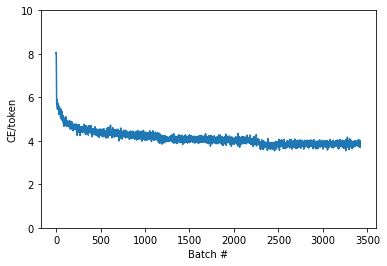

In [62]:
plt.plot(batch_loss.logs)
plt.ylim([0, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [53]:
class Replyer(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=input_text_processor.get_vocabulary(),
            mask_token='',
            invert=True
        )
    )

    # The output should never generate padding, unknown, or start
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=input_text_processor.get_vocabulary(), mask_token=''
    )
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [54]:
replyer = Replyer(
    encoder=train_replyer.encoder,
    decoder=train_replyer.decoder,
    input_text_processor=input_text_processor
)

In [64]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [65]:
Replyer.tokens_to_text = tokens_to_text

In [66]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=input_text_processor.vocabulary_size())
replyer.tokens_to_text(example_output_tokens).numpy()

array([b'emotions uncomfortable', b'scientists dying', b'dew families',
       b'cook minister', b'hahaha access'], dtype=object)

In [67]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else:
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature, num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens 

In [68]:
Replyer.sample = sample

In [85]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                            enc_output=enc_output,
                            mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # One a sequence is done it only produes 0-padding
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break
  
  # Convert the list of generated token IDs to a list of strings
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}    
  

In [86]:
Replyer.reply = translate_unrolled

In [107]:
input_text = [tf.constant('It is a beautiful day.'), tf.constant('How are you doing today?')]
result = replyer.reply(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print()
print(result['text'][1].numpy().decode())
print()

you ' re super cool , very fire ?

if you ' re yelling about it is some expectations , god , i ' m tired



In [108]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_reply(self, input_text):
  return self.reply(input_text)

Replyer.tf_reply = tf_reply

In [109]:
%%time
result = replyer.tf_reply(
    input_text = input_text)

CPU times: total: 38.1 s
Wall time: 41 s


In [111]:
%%time
result = replyer.tf_reply(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

flower sorry you ' re not a stranger ? ! !
please post me thank you

CPU times: total: 219 ms
Wall time: 186 ms


In [112]:
tf.saved_model.save(replyer, 'replyer',
                    signatures={'serving_default': replyer.tf_reply})

INFO:tensorflow:Assets written to: replyer\assets


INFO:tensorflow:Assets written to: replyer\assets


In [116]:
def format_punctuation(s):
    s = s.replace(' , ', ', ')
    s = s.replace(' ! ', '!')
    s = s.replace(' ? ', '?')
    s = s.replace(" ' ", "'")
    return s

In [117]:
print(format_punctuation(result['text'][0].numpy().decode()))
print()
print(format_punctuation(result['text'][1].numpy().decode()))

flower sorry you're not a stranger ?!!

please post me thank you


In [125]:
result = replyer.tf_reply(
    input_text = [tf.constant("I love pizza")])

print(format_punctuation(result['text'][0].numpy().decode()))

how bout pieces with mike!?
